# ODE Parameter Fitting

## System

$$\frac{dX}{dt} = v \cdot \frac{Y^n}{K^n + Y^n} - d \cdot X$$
$$\frac{dY}{dt} = X - d \cdot Y$$

Goal: Fit parameters $v$, $K$, $n$ to experimental data.


In [9]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution

%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)


## Load Experimental Data


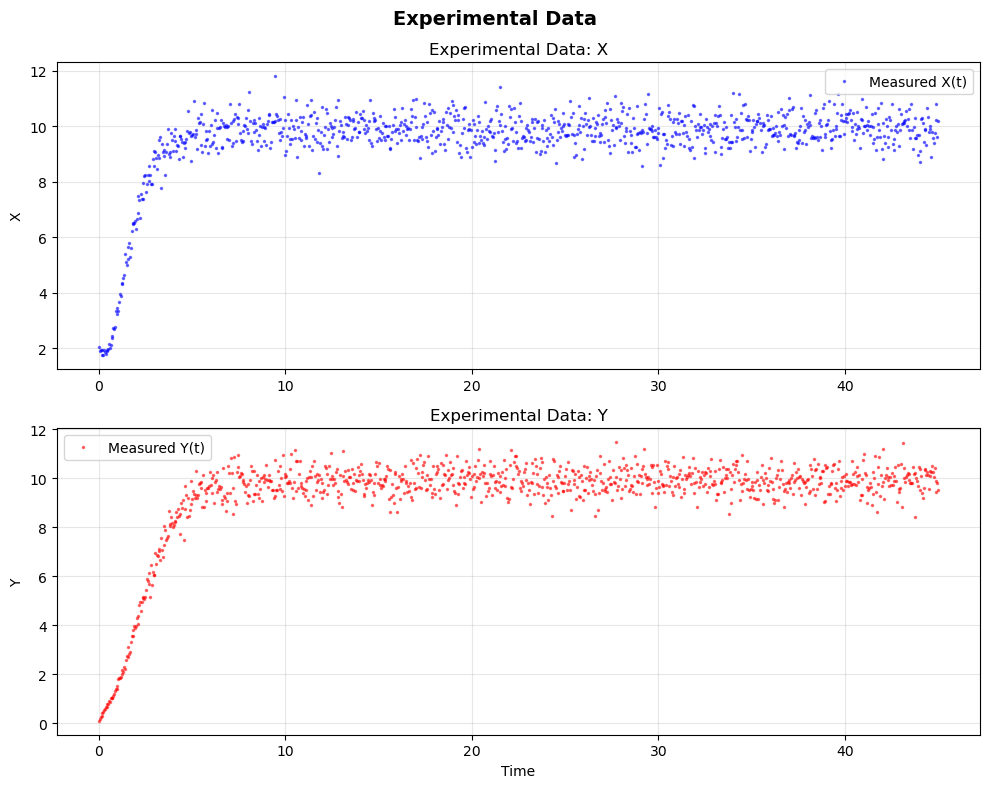

In [10]:
def generate_experimental_data():
    v_true, K_true, n_true, d_true = 10.0, 1.0, 2.0, 1.0
    
    def true_model(t, y):
        X, Y = y
        hill_term = (Y**n_true) / (K_true**n_true + Y**n_true)
        return [v_true * hill_term - d_true * X, X - d_true * Y]
    
    X0, Y0 = 2.0, 0.1
    t_eval = np.linspace(0, 45, 1000)
    sol = solve_ivp(true_model, [0, 45], [X0, Y0], t_eval=t_eval)
    
    noise = 0.05
    X_noisy = sol.y[0] + noise * np.abs(sol.y[0]) * np.random.randn(len(sol.y[0]))
    Y_noisy = sol.y[1] + noise * np.abs(sol.y[1]) * np.random.randn(len(sol.y[1]))
    
    return t_eval, X_noisy, Y_noisy, sol.y[0], sol.y[1]

t_data, X_data, Y_data, X_true, Y_true = generate_experimental_data()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(t_data, X_data, 'b.', label='Measured X(t)', alpha=0.5, markersize=3)
axes[0].set_ylabel('X'); axes[0].set_title('Experimental Data: X'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].plot(t_data, Y_data, 'r.', label='Measured Y(t)', alpha=0.5, markersize=3)
axes[1].set_xlabel('Time'); axes[1].set_ylabel('Y'); axes[1].set_title('Experimental Data: Y'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.suptitle('Experimental Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Implement ODE Model


In [11]:
def self_activation_model(t, y, v, K, n, d):
    X, Y = y
    hill_term = (Y**n) / (K**n + Y**n)
    dX_dt = v * hill_term - d * X
    dY_dt = X - d * Y
    return [dX_dt, dY_dt]


## Test with Initial Guesses


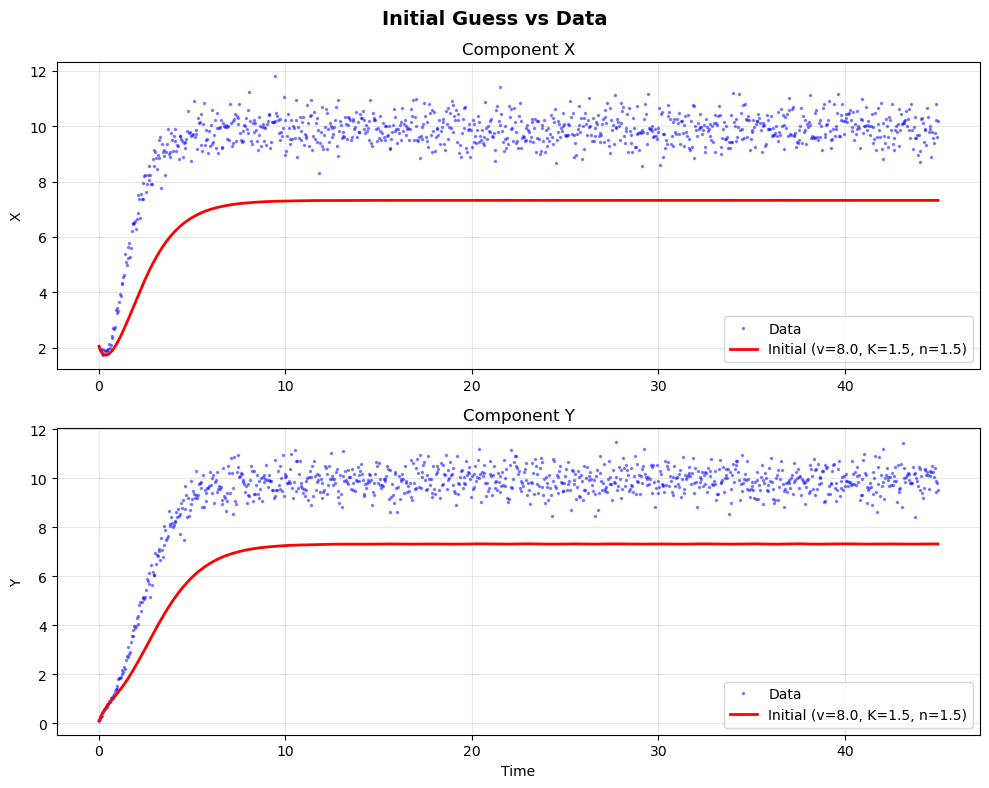

In [12]:
v_guess, K_guess, n_guess, d_known = 8.0, 1.5, 1.5, 1.0
y0_guess = [X_data[0], Y_data[0]]

def solve_model(v, K, n, d, y0, t_span, t_eval):
    sol = solve_ivp(lambda t, y: self_activation_model(t, y, v, K, n, d), t_span, y0, t_eval=t_eval)
    return sol.y[0], sol.y[1]

X_guess, Y_guess = solve_model(v_guess, K_guess, n_guess, d_known, y0_guess, [t_data[0], t_data[-1]], t_data)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(t_data, X_data, 'b.', label='Data', alpha=0.4, markersize=3)
axes[0].plot(t_data, X_guess, 'r-', label=f'Initial (v={v_guess}, K={K_guess}, n={n_guess})', linewidth=2)
axes[0].set_ylabel('X'); axes[0].set_title('Component X'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].plot(t_data, Y_data, 'b.', label='Data', alpha=0.4, markersize=3)
axes[1].plot(t_data, Y_guess, 'r-', label=f'Initial (v={v_guess}, K={K_guess}, n={n_guess})', linewidth=2)
axes[1].set_xlabel('Time'); axes[1].set_ylabel('Y'); axes[1].set_title('Component Y'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.suptitle('Initial Guess vs Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Fit Parameters


In [13]:
def cost_function(params):
    v, K, n = params
    if v <= 0 or K <= 0 or n <= 0:
        return 1e10
    try:
        X_model, Y_model = solve_model(v, K, n, d_known, y0_guess, [t_data[0], t_data[-1]], t_data)
        mse_X = np.mean((X_data - X_model)**2)
        mse_Y = np.mean((Y_data - Y_model)**2)
        return mse_X + mse_Y
    except:
        return 1e10


In [14]:
bounds = [(0.1, 20), (0.1, 5), (0.5, 5)]
result = differential_evolution(cost_function, bounds, maxiter=100, seed=42)
v_fit, K_fit, n_fit = result.x
print(f"Fitted: v={v_fit:.2f}, K={K_fit:.2f}, n={n_fit:.2f}, Cost={result.fun:.4f}")


/var/folders/m5/5bxzcwfn3gjfw_jlxtr50btc0000gn/T/ipykernel_4058/1135199188.py:3: RuntimeWarning: invalid value encountered in scalar power
  hill_term = (Y**n) / (K**n + Y**n)


Fitted: v=10.00, K=1.03, n=2.14, Cost=0.4487


## Visualize Fitted Model


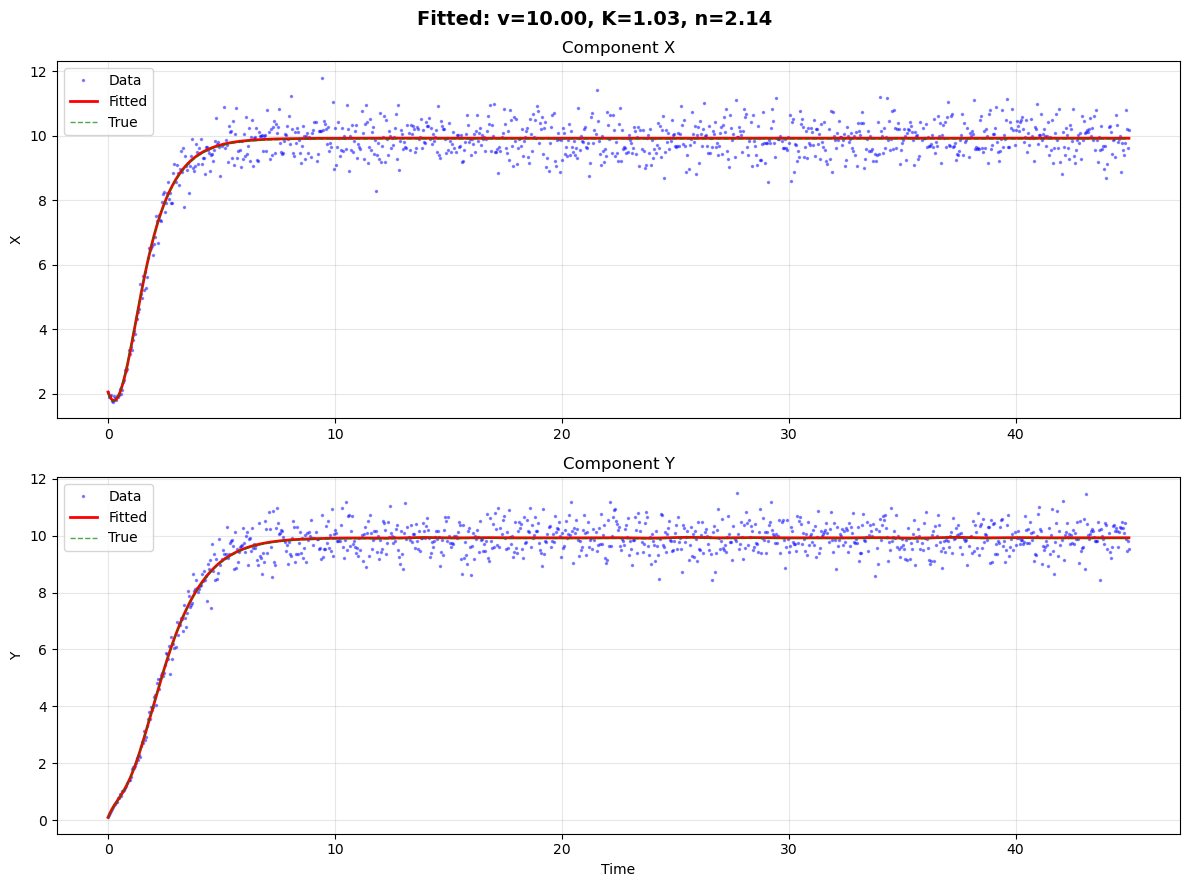

R²: X=0.893, Y=0.937


In [15]:
X_fit, Y_fit = solve_model(v_fit, K_fit, n_fit, d_known, y0_guess, [t_data[0], t_data[-1]], t_data)

fig, axes = plt.subplots(2, 1, figsize=(12, 9))
axes[0].plot(t_data, X_data, 'b.', label='Data', alpha=0.4, markersize=3)
axes[0].plot(t_data, X_fit, 'r-', label='Fitted', linewidth=2)
axes[0].plot(t_data, X_true, 'g--', label='True', linewidth=1, alpha=0.7)
axes[0].set_ylabel('X'); axes[0].set_title('Component X'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].plot(t_data, Y_data, 'b.', label='Data', alpha=0.4, markersize=3)
axes[1].plot(t_data, Y_fit, 'r-', label='Fitted', linewidth=2)
axes[1].plot(t_data, Y_true, 'g--', label='True', linewidth=1, alpha=0.7)
axes[1].set_xlabel('Time'); axes[1].set_ylabel('Y'); axes[1].set_title('Component Y'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.suptitle(f'Fitted: v={v_fit:.2f}, K={K_fit:.2f}, n={n_fit:.2f}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

r2_X = 1 - np.sum((X_data - X_fit)**2) / np.sum((X_data - np.mean(X_data))**2)
r2_Y = 1 - np.sum((Y_data - Y_fit)**2) / np.sum((Y_data - np.mean(Y_data))**2)
print(f"R²: X={r2_X:.3f}, Y={r2_Y:.3f}")


## Visualize Hill Function


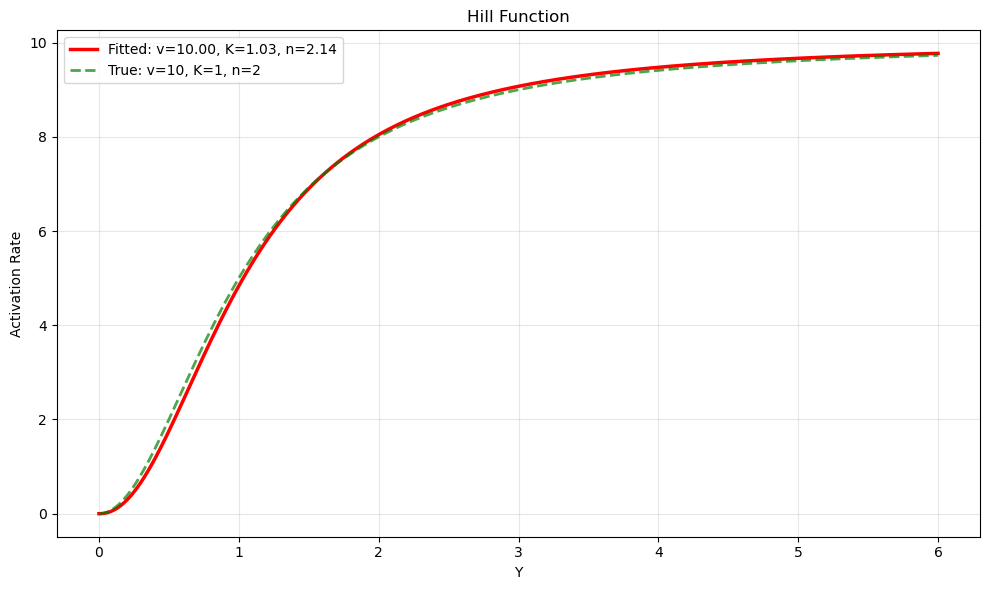

In [16]:
Y_range = np.linspace(0, 6, 300)
hill_fit = v_fit * (Y_range**n_fit) / (K_fit**n_fit + Y_range**n_fit)
v_true, K_true, n_true = 10.0, 1.0, 2.0
hill_true = v_true * (Y_range**n_true) / (K_true**n_true + Y_range**n_true)

plt.figure(figsize=(10, 6))
plt.plot(Y_range, hill_fit, 'r-', linewidth=2.5, label=f'Fitted: v={v_fit:.2f}, K={K_fit:.2f}, n={n_fit:.2f}')
plt.plot(Y_range, hill_true, 'g--', linewidth=2, alpha=0.7, label=f'True: v={v_true:.0f}, K={K_true:.0f}, n={n_true:.0f}')
plt.xlabel('Y'); plt.ylabel('Activation Rate'); plt.title('Hill Function'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Key advantages of physics-based approach:
# • Interpretable parameters with physical meaning
# • Can extrapolate beyond training data  
# • Respects underlying physical constraints
# • Requires relatively few data points
